In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/RWKV-MedSAM2/

/content/drive/MyDrive/RWKV-MedSAM2


In [3]:
!pip install -v -e .

Using pip 24.1.2 from /usr/local/lib/python3.11/dist-packages/pip (python 3.11)
Obtaining file:///content/drive/MyDrive/RWKV-MedSAM2
  Running command python setup.py egg_info
  running egg_info
  creating /tmp/pip-pip-egg-info-ciilvjzy/RWKV_MedSAM2.egg-info
  writing /tmp/pip-pip-egg-info-ciilvjzy/RWKV_MedSAM2.egg-info/PKG-INFO
  writing dependency_links to /tmp/pip-pip-egg-info-ciilvjzy/RWKV_MedSAM2.egg-info/dependency_links.txt
  writing requirements to /tmp/pip-pip-egg-info-ciilvjzy/RWKV_MedSAM2.egg-info/requires.txt
  writing top-level names to /tmp/pip-pip-egg-info-ciilvjzy/RWKV_MedSAM2.egg-info/top_level.txt
  writing manifest file '/tmp/pip-pip-egg-info-ciilvjzy/RWKV_MedSAM2.egg-info/SOURCES.txt'
  reading manifest file '/tmp/pip-pip-egg-info-ciilvjzy/RWKV_MedSAM2.egg-info/SOURCES.txt'
  adding license file 'LICENSE'
  writing manifest file '/tmp/pip-pip-egg-info-ciilvjzy/RWKV_MedSAM2.egg-info/SOURCES.txt'
  Preparing metadata (setup.py) ... done
  Running setup.py develop for 

In [4]:
!pip install sam2

In [5]:
from ext.sam2.build_sam import build_sam2
import os
from hydra import initialize_config_dir
from hydra.core.global_hydra import GlobalHydra

# Clear any existing Hydra config
GlobalHydra.instance().clear()

# Initialize config directory
CONFIG_PATH = "/content/drive/MyDrive/RWKV-MedSAM2/ext/sam2/configs"
initialize_config_dir(config_dir=CONFIG_PATH)

<ipython-input-5-ab4c0bd1dc74>:11: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize_config_dir(config_dir=CONFIG_PATH)


hydra.initialize_config_dir()

In [6]:
# Build model
model = build_sam2(config_file="sam2.1/sam2.1_vcr.yaml", ckpt_path=None, device="cuda")

Using /root/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py311_cu121/wkv/build.ninja...
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module wkv...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module wkv...


In [7]:
model.eval()

SAM2Base(
  (image_encoder): ImageEncoder(
    (trunk): VCRBackbone(
      (stem): VCRStem(
        (conv): Conv2d(3, 112, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (stage0): FusedMbConvStage(
        (blocks): Sequential(
          (0): FusedMbConv(
            (fused_conv): Conv2d(112, 448, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (fused_bn): BatchNorm2d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (fused_act): ReLU(inplace=True)
            (project_conv): Conv2d(448, 112, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (project_bn): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): FusedMbConv(
            (fused_conv): Conv2d(112, 448, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [8]:
# Save the checkpoint
checkpoint = {
    'model': model.state_dict(),
    'config_file': "/content/drive/MyDrive/RWKV-MedSAM2/ext/sam2/configs/sam2.1/sam2.1_vcr.yaml",
}

In [9]:
import torch

# Save to file
save_path = "checkpoints/sam2_vcr.pt"
torch.save(checkpoint, save_path)
print(f"Model saved to {save_path}")

Model saved to checkpoints/sam2_vcr.pt


In [10]:
!pip install opencv-python matplotlib

In [11]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [12]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [13]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [14]:
image = Image.open('images/truck.jpg')
image = np.array(image.convert("RGB"))

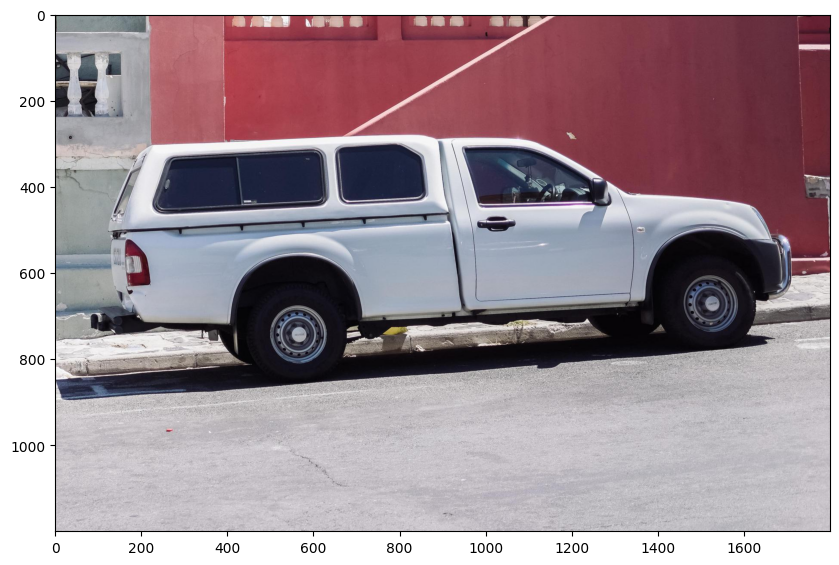

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [16]:
from sam2.sam2_image_predictor import SAM2ImagePredictor

predictor = SAM2ImagePredictor(model)

In [19]:
predictor.set_image(image)

Stem out: torch.Size([1, 112, 512, 512])
feat0: torch.Size([1, 112, 256, 256])
feat1: torch.Size([1, 224, 128, 128])
feat2: torch.Size([1, 448, 64, 64])
feat3: torch.Size([1, 896, 32, 32])


In [21]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

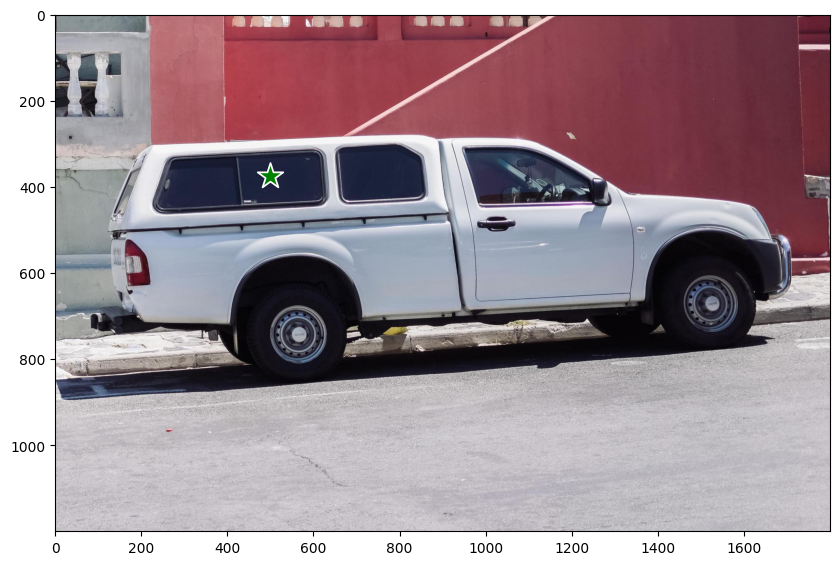

In [22]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [23]:
print(predictor._features["image_embed"].shape, predictor._features["image_embed"][-1].shape)

torch.Size([1, 256, 64, 64]) torch.Size([256, 64, 64])


In [24]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

In [31]:
masks.shape  # (number_of_masks) x H x W

(3, 1200, 1800)

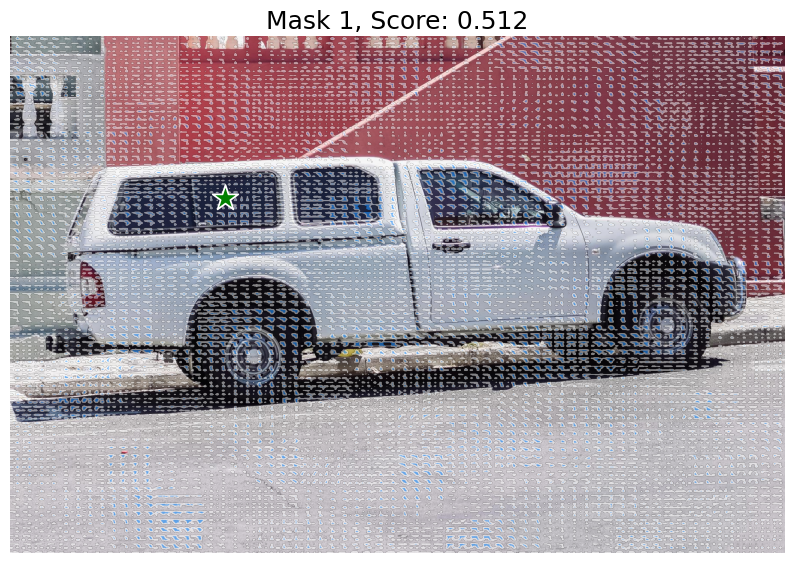

In [ ]:
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)